In [1]:
from GT import get_dataset
import matplotlib.pyplot as plt
from GT import GTM
import json
import torch
import numpy as np
import pandas as pd

import os
import seaborn as sns
from tsl.datasets import AirQuality
from Notebooks.Eval.VisualEval import plot_pca


DATASET_NAME = 'AirQuality'
MODEL_NAME= 'GMM2'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [2]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [3]:
# Model Parameters 100 hidden
hidden_size = 64
num_layers = 1
lr = 0.001
weight_decay = 0.001
# weight_decay = 0
dropout = 0.1
bidirectional = True
mixture_dim = 28
train_from_checkpoint = True

max_size = 8736//4

dataset = AirQuality(small=True, impute_nans=True)

exo = dataset.datetime_encoded('day').values

dataset = dataset.dataframe()[:max_size]
exo = exo[:max_size]

In [4]:
dataset.values.shape, exo.shape

((2184, 36), (2184, 2))

## Dataset

In [5]:
# Dataset Split\
Train, Validation, Test = get_dataset('AirQuality', dataset, 168)

# Train[..., 0] = Train[..., 5]

train_data = Train
train_data = torch.Tensor(train_data)
exo_var = torch.Tensor(exo).reshape(train_data.shape[0], train_data.shape[1], 2)
# exo_var = []

input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)
exo_size = 2

# exo_var = (exo_var - exo_var.min()) / (exo_var.max() - exo_var.min())  

AirQuality DATA
Original Dataset: 	39
Train Split: 		13 	(70%)
Validation Split: 	13 	(20%)
Test Split: 		13 	(10%)


In [6]:
Train.shape

(13, 168, 36)

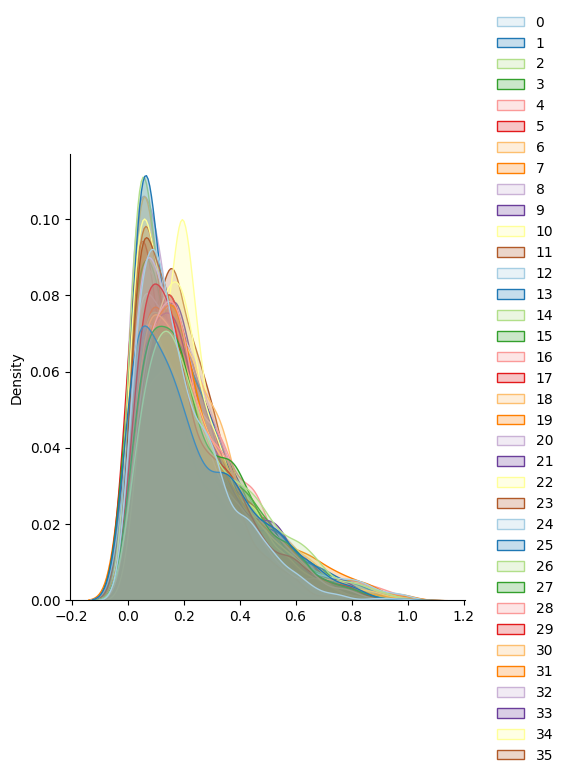

In [7]:
sns.displot(train_data.view(train_data.shape[0]*train_data.shape[1], train_data.shape[2]), fill=True, kind='kde', palette='Paired')
plt.show()

## Model Train

In [8]:
# Model Train
model = GTM(input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, exo_size)

configs = input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, exo_size
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except: 
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, exo_var, batch_size=1, window=23, horizon=1, epochs=100)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_32157/60743291.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless

Model not present or incompatible
Starting training...


Loss 4.390476609324361: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 1 - loss: 4.390476609324361


Loss 3.872119452927139: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s] 


Epoch 2 - loss: 3.872119452927139


Loss 3.6980932361477024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Epoch 3 - loss: 3.6980932361477024


Loss 3.5847727964212606: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 4 - loss: 3.5847727964212606


Loss 3.50050911798582: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]  


Epoch 5 - loss: 3.50050911798582


Loss 3.4338862895965576: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 6 - loss: 3.4338862895965576


Loss 3.3713498325138302: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 7 - loss: 3.3713498325138302


Loss 3.322232969514616: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s] 


Epoch 8 - loss: 3.322232969514616


Loss 3.275262814301711: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s] 


Epoch 9 - loss: 3.275262814301711


Loss 3.2341190432454203: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 10 - loss: 3.2341190432454203


Loss 3.2074035655011186: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 11 - loss: 3.2074035655011186


Loss 3.160350364643139: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s] 


Epoch 12 - loss: 3.160350364643139


Loss 3.145101811859634: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 13 - loss: 3.145101811859634


Loss 3.106538625863882: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s] 


Epoch 14 - loss: 3.106538625863882


Loss 3.084569420133318: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s] 


Epoch 15 - loss: 3.084569420133318


Loss 3.0650613700950537: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 16 - loss: 3.0650613700950537


Loss 3.030372381210327: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s] 


Epoch 17 - loss: 3.030372381210327


Loss 3.0246915319463707: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 18 - loss: 3.0246915319463707


Loss 3.0019428992009427: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Epoch 19 - loss: 3.0019428992009427


Loss 2.9895084690261675: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 20 - loss: 2.9895084690261675


Loss 2.9551156012566535: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Epoch 21 - loss: 2.9551156012566535


Loss 2.965155276623401: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s] 


Epoch 22 - loss: 2.965155276623401


Loss 2.9367924365368516: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 23 - loss: 2.9367924365368516


Loss 2.936829645555098: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s] 


Epoch 24 - loss: 2.936829645555098


Loss 2.9173600647475695: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 25 - loss: 2.9173600647475695


Loss 2.9093691490508697: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]


Epoch 26 - loss: 2.9093691490508697


Loss 2.8911933374928904: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 27 - loss: 2.8911933374928904


Loss 2.8934665276454044: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 28 - loss: 2.8934665276454044


Loss 2.8844971028003066: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 29 - loss: 2.8844971028003066


Loss 2.8691299511836124: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 30 - loss: 2.8691299511836124


Loss 2.855690115100735: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s] 


Epoch 31 - loss: 2.855690115100735


Loss 2.854299157530397: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s] 


Epoch 32 - loss: 2.854299157530397


Loss 2.8414598926083072: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Epoch 33 - loss: 2.8414598926083072


Loss 2.838273601217584: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s] 


Epoch 34 - loss: 2.838273601217584


Loss 2.8278075679317936: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 35 - loss: 2.8278075679317936


Loss 2.8291206674261407: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Epoch 36 - loss: 2.8291206674261407


Loss 2.824164872641092: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s] 


Epoch 37 - loss: 2.824164872641092


Loss 2.8003564981313853: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 38 - loss: 2.8003564981313853


Loss 2.806213989362612: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s] 


Epoch 39 - loss: 2.806213989362612


Loss 2.806033946655609: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s] 


Epoch 40 - loss: 2.806033946655609


Loss 2.7898994461520688: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 41 - loss: 2.7898994461520688


Loss 2.7949052904988383: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 42 - loss: 2.7949052904988383


Loss 2.785503062573108: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s] 


Epoch 43 - loss: 2.785503062573108


Loss 2.7858462779076545: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 44 - loss: 2.7858462779076545


Loss 2.7745326298933763: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 45 - loss: 2.7745326298933763


Loss 2.777650704750648: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s] 


Epoch 46 - loss: 2.777650704750648


Loss 2.7706433626321645: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 47 - loss: 2.7706433626321645


Loss 2.7626090757139434: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 48 - loss: 2.7626090757139434


Loss 2.764408588409424: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Epoch 49 - loss: 2.764408588409424


Loss 2.754066425365406: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s] 


Epoch 50 - loss: 2.754066425365406


Loss 2.7608221075037025: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 51 - loss: 2.7608221075037025


Loss 2.7567060727339525: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Epoch 52 - loss: 2.7567060727339525


Loss 2.749506203682868: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s] 


Epoch 53 - loss: 2.749506203682868


Loss 2.7439748297680864: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 54 - loss: 2.7439748297680864


Loss 2.749217680522374: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s] 


Epoch 55 - loss: 2.749217680522374


Loss 2.7403069459475002: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 56 - loss: 2.7403069459475002


Loss 2.7319499241126763: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Epoch 57 - loss: 2.7319499241126763


Loss 2.750945887722812: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s] 


Epoch 58 - loss: 2.750945887722812


Loss 2.7404756991417853: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 59 - loss: 2.7404756991417853


Loss 2.7273779256003245: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 60 - loss: 2.7273779256003245


Loss 2.7256157922220754: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Epoch 61 - loss: 2.7256157922220754


Loss 2.728282173911294: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s] 


Epoch 62 - loss: 2.728282173911294


Loss 2.7268908888429078: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Epoch 63 - loss: 2.7268908888429078


Loss 2.7242686722304796: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 64 - loss: 2.7242686722304796


Loss 2.720140441433414: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s] 


Epoch 65 - loss: 2.720140441433414


Loss 2.7192549050509274: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 66 - loss: 2.7192549050509274


Loss 2.712604119227483: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s] 


Epoch 67 - loss: 2.712604119227483


Loss 2.717411159159063: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s] 


Epoch 68 - loss: 2.717411159159063


Loss 2.708977290562221: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s] 


Epoch 69 - loss: 2.708977290562221


Loss 2.7167889914669834: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 70 - loss: 2.7167889914669834


Loss 2.703153018113021: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s] 


Epoch 71 - loss: 2.703153018113021


Loss 2.711558996976077: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s] 


Epoch 72 - loss: 2.711558996976077


Loss 2.707205879819262: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s] 


Epoch 73 - loss: 2.707205879819262


Loss 2.703333938514793: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s] 


Epoch 74 - loss: 2.703333938514793


Loss 2.6990061775668637: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 75 - loss: 2.6990061775668637


Loss 2.6996335144881365: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 76 - loss: 2.6996335144881365


Loss 2.702442315908579: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Epoch 77 - loss: 2.702442315908579


Loss 2.696306729054713: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s] 


Epoch 78 - loss: 2.696306729054713


Loss 2.704227319130531: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s] 


Epoch 79 - loss: 2.704227319130531


Loss 2.695425630925776: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s] 


Epoch 80 - loss: 2.695425630925776


Loss 2.6944098210596774: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Epoch 81 - loss: 2.6944098210596774


Loss 2.6845537017989947: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch 82 - loss: 2.6845537017989947


Loss 2.688233503928551: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s] 


Epoch 83 - loss: 2.688233503928551


Loss 2.6865796728448554: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]


Epoch 84 - loss: 2.6865796728448554


Loss 2.689579332267845: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 85 - loss: 2.689579332267845


Loss 2.6967157400571384: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Epoch 86 - loss: 2.6967157400571384


Loss 2.6787529227497813: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Epoch 87 - loss: 2.6787529227497813


Loss 2.6848143221257805: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Epoch 88 - loss: 2.6848143221257805


Loss 2.6806233662825365: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]


Epoch 89 - loss: 2.6806233662825365


Loss 2.679745068916908: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s] 


Epoch 90 - loss: 2.679745068916908


Loss 2.6848501975719747: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Epoch 91 - loss: 2.6848501975719747


Loss 2.6836693994291534: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]


Epoch 92 - loss: 2.6836693994291534


Loss 2.668441958479829: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s] 


Epoch 93 - loss: 2.668441958479829


Loss 2.6732805299234914: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Epoch 94 - loss: 2.6732805299234914


Loss 2.672528848543272: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s] 


Epoch 95 - loss: 2.672528848543272


Loss 2.6752034700833836: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 96 - loss: 2.6752034700833836


Loss 2.673694435056749: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s] 


Epoch 97 - loss: 2.673694435056749


Loss 2.6776987798921357: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]


Epoch 98 - loss: 2.6776987798921357


Loss 2.6660159734579234: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]


Epoch 99 - loss: 2.6660159734579234


Loss 2.670187208678696: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s] 

Epoch 100 - loss: 2.670187208678696


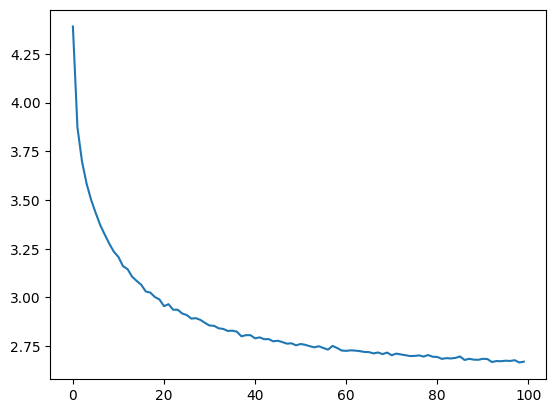

<Figure size 640x480 with 0 Axes>

In [9]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

In [10]:
output = model.generate_step(shape=(10, 168, 38), exo_var=exo_var.view(exo_var.shape[0]*exo_var.shape[1], exo_var.shape[2])[:1910].view(10, 191, exo_var.shape[2]), window = 23, horizon=1)
prediction = model.predict_step(data=train_data[0:10], exo_var=exo_var[:10], steps=168)
prediction2 = model.predict_step(torch.tensor(output[:10]), exo_var[:10], steps=168)

100%|██████████| 168/168 [00:14<00:00, 11.68it/s]


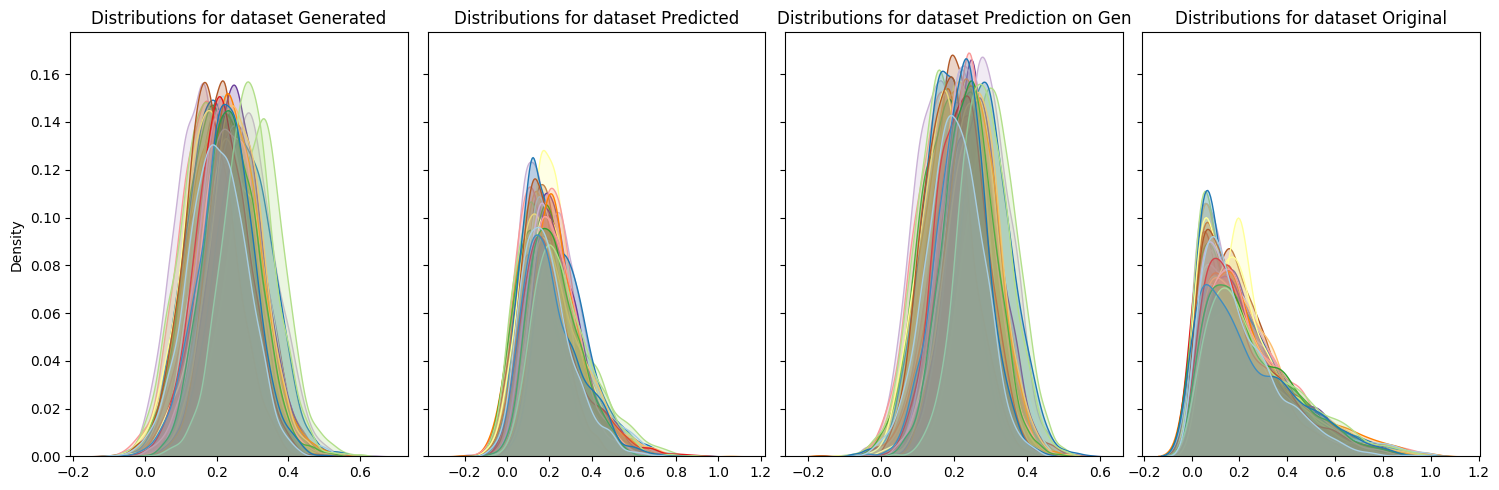

In [11]:
def plot_dist(datasets, kind='kde'):
    # Create a figure with 3 subplots
    fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5), sharey=True, sharex=False)
    if kind == 'box':
        plot_ = sns.boxplot
    elif kind == 'ecdf':
        plot_ = sns.ecdfplot
    elif kind == 'kde':
        plot_ = sns.kdeplot
    else:
        plot_ = sns.histplot

    reshaped_output = {}
    for key, gen in datasets.items():
        # Reshape the data to combine samples and time steps (flatten them)
        reshaped_output[key] = gen.reshape(gen.shape[0] * gen.shape[1], gen.shape[2])
        
    # Plot KDE for each feature (assuming output has 3 features)
    for i, item in zip(range(0, len(reshaped_output)), reshaped_output.items()):
        k, data = item
        if kind == 'kde':
            plot_(data, ax=ax[i], palette='Paired', fill=True, legend=False)
        else:
            plot_(data, ax=ax[i], palette='Paired')
        ax[i].set_title(f'Distributions for dataset {k}')

    # Show the plot
    plt.tight_layout()
    plt.show()
# plot_dist({'Generated': output, 'Original': train_data}, 'kde')
plot_dist({'Generated': output, 'Predicted': prediction, 'Prediction on Gen': prediction2, 'Original': train_data}, 'kde')

/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_32157/658949032.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.reshape(train_data.shape[0]*train_data.shape[1], -1))
/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_32157/658949032.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750b

<Axes: ylabel='Density'>

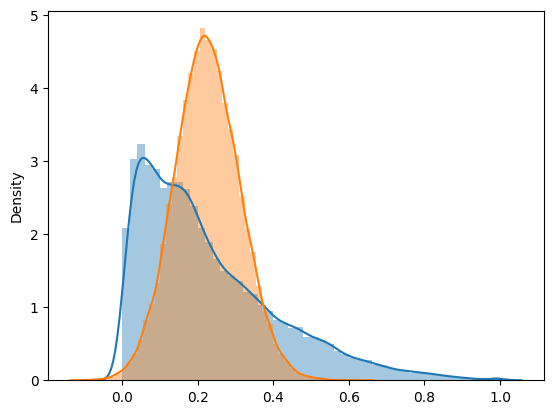

In [17]:
sns.distplot(train_data.reshape(train_data.shape[0]*train_data.shape[1], -1))
sns.distplot(output.reshape(output.shape[0]*output.shape[1], -1))

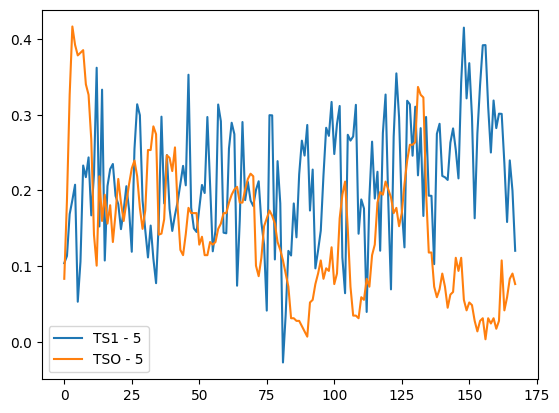

In [16]:
# plt.plot(output[3, :, 0], label='TS1 - 0')
# plt.plot(output[0, :, 1], label='TS1 - 1')
# plt.plot(output[0, :, 2], label='TS1 - 2')
# plt.plot(output[0, :, 3], label='TS1 - 3')
# plt.plot(output[0, :, 4], label='TS1 - 4')
plt.plot(output[3, :, 5], label='TS1 - 5') 

# plt.plot(output1[0, :, 0], label='TS2 - 0')
# plt.plot(output1[0, :, 1], label='TS2 - 1')
# plt.plot(output1[0, :, 2], label='TS2 - 2')
# plt.plot(output1[0, :, 3], label='TS2 - 3')
# plt.plot(output1[0, :, 4], label='TS2 - 4')
# plt.plot(output1[0, :, 5], label='TS2 - 5') 


# plt.plot(prediction[0, :, 0], label='Pred - 0')
# plt.plot(prediction[0, :, 1], label='Pred - 1')
# plt.plot(prediction[0, :, 2], label='Pred - 2')
# plt.plot(prediction[0, :, 3], label='Pred - 3')
# plt.plot(prediction[0, :, 4], label='Pred - 4')
# plt.plot(prediction[1, :, 5], label='Pred - 5')


# plt.plot(train_data[1, :, 0], label='TSO - 0')
# plt.plot(train_data[0, :, 1], label='TSO - 1')
# plt.plot(train_data[0, :, 2], label='TSO - 2')
# plt.plot(train_data[0, :, 3], label='TSO - 3')
# plt.plot(train_data[0, :, 4], label='TSO - 4')
plt.plot(train_data[1, :, 5], label='TSO - 5')
plt.legend()
plt.show()

22


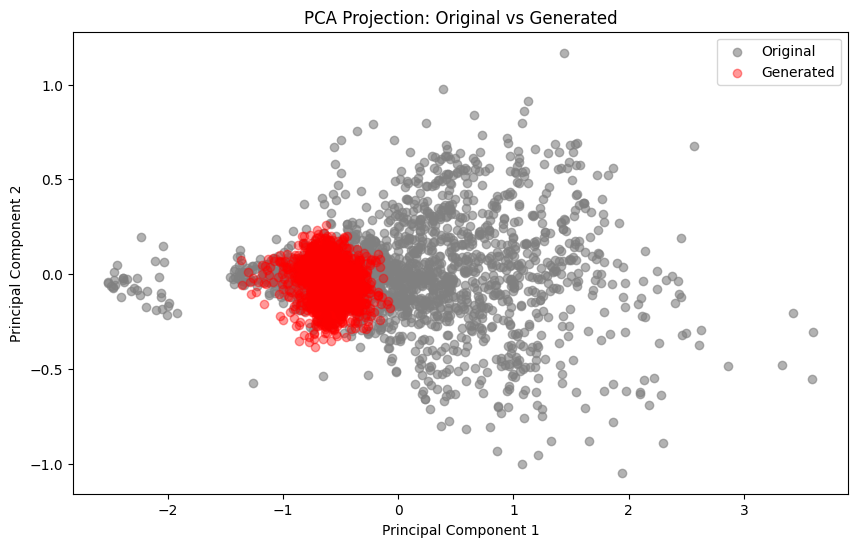

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


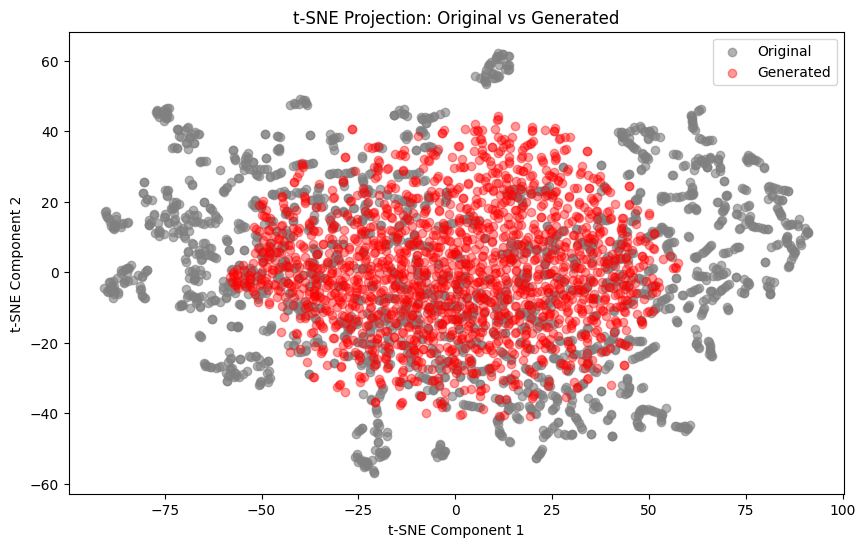

In [13]:
from Notebooks.Eval.VisualEval import plot_pca, plot_tsne

# plot_pca(train_data[:10], prediction[:10], component_to_plot=(0, 1))
plot_pca(train_data, output, component_to_plot=(0, 1))
plot_tsne(train_data.view(train_data.shape[0]*train_data.shape[1], train_data.shape[2]), torch.Tensor(output).view(output.shape[0]*output.shape[1], output.shape[2]))

22


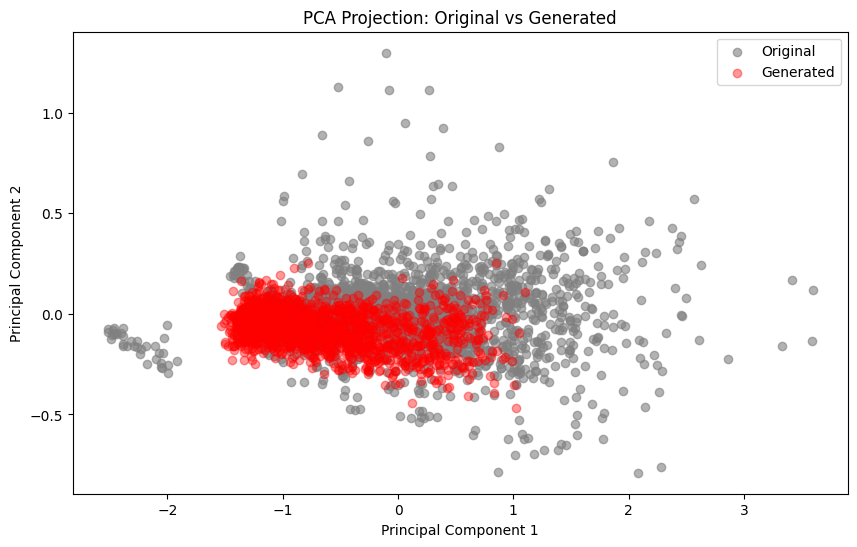

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


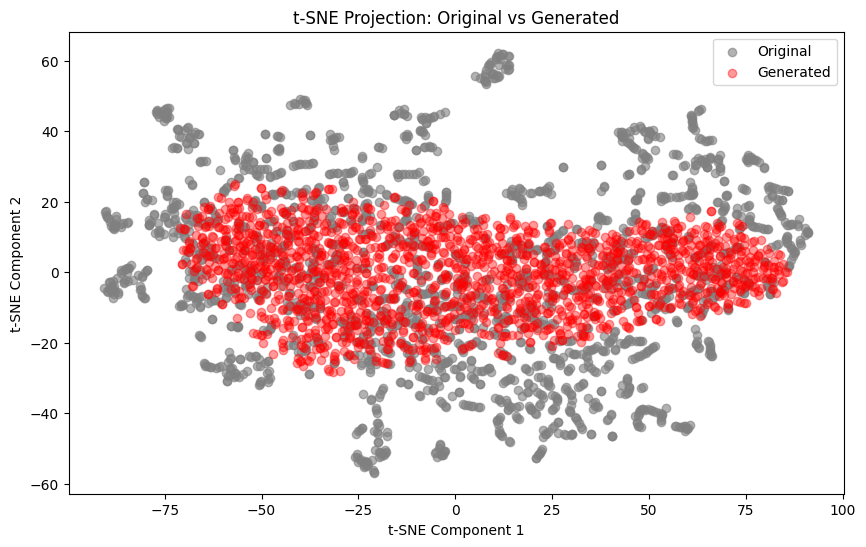

In [14]:

plot_pca(train_data, prediction, component_to_plot=(0, 2))
plot_tsne(train_data.view(train_data.shape[0]*train_data.shape[1], train_data.shape[2]), torch.Tensor(prediction).view(prediction.shape[0]*prediction.shape[1], prediction.shape[2]))